###Connet to Drive

In [ ]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My Drive/competition

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/competition


###Import libraries

In [ ]:
# Fix randomness and hide warnings
seed = 42

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd()+'/configs/'

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

import numpy as np
np.random.seed(seed)

import logging

import random
random.seed(seed)

In [ ]:
# Import tensorflow
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl
from keras import backend as K
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)
print(tf.__version__)

2.14.0


In [ ]:
# Import other libraries
import cv2
#from tensorflow.keras.applications.mobilenet import preprocess_input
#from tensorflow.keras.applications.efficientnet import preprocess_input
#from tensorflow.keras.applications.resnet50 import preprocess_input
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
import seaborn as sns


In [ ]:
pip install keras-cv

In [ ]:
import keras_cv

Using TensorFlow backend


##Triplet siamese


In [ ]:
#load dataset
load_data = np.load('balanced_dataset_v1.npz', allow_pickle=True)

images = np.array(load_data['data'])#.astype(np.uint8))
y = np.array(load_data['labels'])
labels = {'healthy':0, 'unhealthy':1}

#normalize images
#images = images[:] / 255

In [ ]:
# Split data into training and validation sets, maintaining class distribution
X_train, X_val, y_train, y_val = train_test_split(images, y, random_state=seed, test_size=0.1, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, random_state=seed, test_size=0.2, stratify=y_train)

del images
del y

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train*255.
X_test = X_test*255.
X_val = X_val.astype('float32')
X_val = X_val*255.

y_train = y_train.astype(int)
y_test = y_test.astype(int)
y_val = y_val.astype(int)

In [ ]:
# Define key model parameters
input_shape = X_train.shape[1:]  # Input shape for the model
output_shape = 1                 # Output shape for the model
epochs = 200                     # Number of training epochs
lr = 1e-4
batch_size = 32
dim = 20                         # Dimension of the vectorial representation of the image
alpha = 0.5                      # Margin for contrastive loss

In [ ]:
def get_image(label, test=False):
    """Choose an image from our training or test data with the
    given label."""
    if test:
        y = y_val; X = X_val
    else:
        y = y_train; X = X_train
    idx = np.random.randint(len(y))
    while y[idx] != label:
        # keep searching randomly!
        idx = np.random.randint(len(y))
    return X[idx]

def get_triplet(test=False,batch_size=batch_size):
    """Choose a triplet (anchor, positive, negative) of images
    such that anchor and positive have the same label and
    anchor and negative have different labels."""
    n = a = np.random.randint(0,2)
    while n == a:
        # keep searching randomly!
        n = np.random.randint(0,2)
    a, p = get_image(a, test), get_image(a, test)
    n = get_image(n, test)
    return a, p, n

def generate_triplets(test=False,batch_size=batch_size):
    """Generator of triplets for
    training or test."""
    while True:
        list_a = []
        list_p = []
        list_n = []

        for i in range(batch_size):
            a, p, n = get_triplet(test)
            list_a.append(a)
            list_p.append(p)
            list_n.append(n)

        A = np.array(list_a, dtype='float32')
        P = np.array(list_p, dtype='float32')
        N = np.array(list_n, dtype='float32')
        # a "dummy" label which will come in to our identity loss
        # function below as y_true. We'll ignore it.
        label = np.ones(batch_size)
        yield [A, P, N], label


In [ ]:
def identity_loss(y_true, y_pred):
    return K.mean(y_pred)

def triplet_loss(x, alpha = 0.5):
    # Triplet Loss function.
    anchor,positive,negative = x
    # distance between the anchor and the positive
    pos_dist = K.sum(K.square(anchor-positive),axis=1)
    # distance between the anchor and the negative
    neg_dist = K.sum(K.square(anchor-negative),axis=1)
    # compute loss
    basic_loss = pos_dist-neg_dist+alpha
    loss = K.maximum(basic_loss,0.0)
    return loss


In [ ]:
# Preprocessing functions for tfkl.Lambda

from tensorflow.keras.applications.mobilenet_v2 import preprocess_input as pr_mobile
from tensorflow.keras.applications.resnet50 import preprocess_input as pr_resnet
from tensorflow.keras.applications.xception import preprocess_input as pr_xception

def my_mobile_preprocessing(X):
  return pr_mobile(X)

def my_resnet_preprocessing(X):
  return pr_resnet(X)

def my_xception_preprocessing(X):
  return pr_xception(X)

In [ ]:
pip install keras-cv

In [ ]:
def embedding_model(input_shape=input_shape,emb_dim=dim):
    """Encoding network part of the model"""

    # Projections layers from output of pre-trained model to vector of dimension emb_dim
    projection_head4 = tf.keras.Sequential([
        tfkl.Dense(emb_dim, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer41')
    ])

    projection_net1 = tf.keras.Sequential([
      tfkl.Dense(512, activation='relu',kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer11'),
      tfkl.Dropout(0.2),
      tfkl.Dense(256, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer12'),
      tfkl.Dropout(0.2),
      tfkl.Dense(128, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer13')
    ])

    projection_net2 = tf.keras.Sequential([
      tfkl.Dense(512, activation='relu',kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer21'),
      tfkl.Dropout(0.2),
      tfkl.Dense(256, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer22'),
      tfkl.Dropout(0.2),
      tfkl.Dense(128, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer23')
    ])

    projection_net3 = tf.keras.Sequential([
      tfkl.Dense(512, activation='relu',kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer31'),
      tfkl.Dropout(0.2),
      tfkl.Dense(256, activation='relu', kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer32'),
      tfkl.Dropout(0.2),
      tfkl.Dense(128, kernel_initializer=tfk.initializers.HeUniform(seed=seed), name='projection_layer33')
    ])


    # Load pretrained models
    pretrained_model1 = tf.keras.applications.EfficientNetV2B0(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
        )

    pretrained_model2 = tf.keras.applications.EfficientNetV2B3(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
        )

    pretrained_model3 = tf.keras.applications.EfficientNetV2S(
        weights='imagenet',
        include_top=False,
        input_shape=(224, 224, 3),
        pooling='avg'
        )


    pretrained_model1.trainable = False
    pretrained_model2.trainable = False
    pretrained_model3.trainable = False

    input = tfk.Input(shape=input_shape)
    x0 = tfkl.Resizing(224,224)(input)

    #x3 = tfkl.Lambda(my_xception_preprocessing)(x0)
    #x2 = tfkl.Lambda(my_mobile_preprocessing)(x0)

    x1 = pretrained_model1(x0)
    x2 = pretrained_model2(x0)
    x3 = pretrained_model3(x0)

    x1 = projection_net1(x1)
    x2 = projection_net2(x2)
    x3 = projection_net3(x3)


    x = tfkl.Add()([x1,x2,x3])
    output = projection_head4(x)

    model = tfk.Model(inputs=input, outputs=output)
    return model


def complete_model(base_model,input_shape=input_shape,LR=lr):
    """Create the complete model with three
     embedding models and minimize the loss
     between their output embeddings"""

    #Preprocessing layers
    augmentation = tf.keras.Sequential([
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.2),
    ], name='augmentation')

    augmentation_cv = tf.keras.Sequential([
        keras_cv.layers.Solarization(value_range=[0, 255]),
        keras_cv.layers.RandomShear(),
        keras_cv.layers.Equalization(value_range=[0, 255]),
        keras_cv.layers.Posterization(value_range=[0, 255], bits=5),
        keras_cv.layers.AutoContrast(value_range=[0,255])
    ], name='augmentation_cv')

    input_1 = tfk.Input(shape=input_shape)
    input_2 = tfk.Input(shape=input_shape)
    input_3 = tfk.Input(shape=input_shape)

    A = augmentation(input_1)
    P = augmentation(input_2)
    N = augmentation(input_3)

    A = augmentation_cv(A)
    P = augmentation_cv(P)
    N = augmentation_cv(N)

    A = base_model(A)
    P = base_model(P)
    N = base_model(N)

    #A = tfkl.LayerNormalization()(A)
    #P = tfkl.LayerNormalization()(P)
    #N = tfkl.LayerNormalization()(N)

    loss = tfkl.Lambda(triplet_loss)([A, P, N])
    model = tfk.Model(inputs=[input_1, input_2, input_3], outputs=loss)
    model.compile(loss=identity_loss, optimizer=tfk.optimizers.Adam(LR))
    return model


In [ ]:
base_model = embedding_model()
#base_model = tfk.models.load_model('embeddings_large2')

82420632/82420632 [==============================] - 3s 0us/step


In [ ]:
base_model.get_layer('efficientnetv2-b0').trainable = True
base_model.get_layer('efficientnetv2-b3').trainable = True
base_model.get_layer('efficientnetv2-s').trainable = True

In [ ]:
for _, layer in enumerate(base_model.get_layer('efficientnetv2-b0').layers):
  if 'block6' in layer.name:
    if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False
  else:
    layer.trainable = False

for i, layer in enumerate(base_model.get_layer('efficientnetv2-b0').layers[-4:]):
  if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True

for i, layer in enumerate(base_model.get_layer('efficientnetv2-b0').layers):
   print(i, layer.name, layer.trainable)


0 input_3 False
1 rescaling_2 False
2 normalization_2 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
3

In [ ]:
for _, layer in enumerate(base_model.get_layer('efficientnetv2-b3').layers):
  if 'block6' in layer.name:
    if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False
  else:
    layer.trainable = False

for i, layer in enumerate(base_model.get_layer('efficientnetv2-b3').layers[-4:]):
  if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True

for i, layer in enumerate(base_model.get_layer('efficientnetv2-b3').layers):
   print(i, layer.name, layer.trainable)


0 input_4 False
1 rescaling_3 False
2 normalization_3 False
3 stem_conv False
4 stem_bn False
5 stem_activation False
6 block1a_project_conv False
7 block1a_project_bn False
8 block1a_project_activation False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block3a_expand_conv False
34 block3a_expand_bn False
35 block3a_expand_activation False
36 block3a_project_conv False
3

In [ ]:
for _, layer in enumerate(base_model.get_layer('efficientnetv2-s').layers):
  if 'block6' in layer.name:
    if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True
    else:
      layer.trainable = False
  else:
    layer.trainable = False

for i, layer in enumerate(base_model.get_layer('efficientnetv2-s').layers[-4:]):
  if not isinstance(layer, tfkl.BatchNormalization):
      layer.trainable = True

for i, layer in enumerate(base_model.get_layer('efficientnetv2-s').layers):
   print(i, layer.name, layer.trainable)


0 input_5 False
1 rescaling_4 False
2 stem_conv False
3 stem_bn False
4 stem_activation False
5 block1a_project_conv False
6 block1a_project_bn False
7 block1a_project_activation False
8 block1a_add False
9 block1b_project_conv False
10 block1b_project_bn False
11 block1b_project_activation False
12 block1b_drop False
13 block1b_add False
14 block2a_expand_conv False
15 block2a_expand_bn False
16 block2a_expand_activation False
17 block2a_project_conv False
18 block2a_project_bn False
19 block2b_expand_conv False
20 block2b_expand_bn False
21 block2b_expand_activation False
22 block2b_project_conv False
23 block2b_project_bn False
24 block2b_drop False
25 block2b_add False
26 block2c_expand_conv False
27 block2c_expand_bn False
28 block2c_expand_activation False
29 block2c_project_conv False
30 block2c_project_bn False
31 block2c_drop False
32 block2c_add False
33 block2d_expand_conv False
34 block2d_expand_bn False
35 block2d_expand_activation False
36 block2d_project_conv False
37 bl

In [ ]:
model = complete_model(base_model)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_7 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_8 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 input_9 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 augmentation (Sequential)   (None, 96, 96, 3)            0         ['input_7[0][0]',             
                                                                     'input_8[0][0]',       

In [ ]:
train_generator = generate_triplets()
test_generator = generate_triplets(test=True)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', mode='min', patience=6, start_from_epoch=0, restore_best_weights=True)

lr_patience = 4
lr_scheduler = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',     # Metric to monitor
    patience=lr_patience,   # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.8,             # Factor by which the learning rate will be reduced (0.8 in this case)
    mode='min',             # Mode to decide when to reduce learning rate
    min_lr=1e-6,            # Minimum learning rate
    start_from_epoch=10
)

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath = '/gdrive/My Drive/competition',
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
def lr_warmup_cosine_decay(global_step,
                           warmup_steps,
                           hold = 0,
                           total_steps=0,
                           start_lr=0.0,
                           target_lr=1e-3):
    # Cosine decay
    learning_rate = 0.5 * target_lr * (1 + np.cos(np.pi * (global_step - warmup_steps - hold) / float(total_steps - warmup_steps - hold)))

    # Target LR * progress of warmup (=1 at the final warmup step)
    warmup_lr = target_lr * (global_step / warmup_steps)

    # Choose between `warmup_lr`, `target_lr` and `learning_rate` based on whether `global_step < warmup_steps` and we're still holding.
    # i.e. warm up if we're still warming up and use cosine decayed lr otherwise
    if hold > 0:
        learning_rate = np.where(global_step > warmup_steps + hold,
                                 learning_rate, target_lr)

    learning_rate = np.where(global_step < warmup_steps, warmup_lr, learning_rate)
    return learning_rate

In [ ]:
from keras import backend as K

class WarmupCosineDecay(tfk.callbacks.Callback):
    def __init__(self, total_steps=0, warmup_steps=0, start_lr=0.0, target_lr=1e-3, hold=0):

        super(WarmupCosineDecay, self).__init__()
        self.start_lr = start_lr
        self.hold = hold
        self.total_steps = total_steps
        self.global_step = 0
        self.target_lr = target_lr
        self.warmup_steps = warmup_steps
        self.lrs = []

    def on_batch_end(self, batch, logs=None):
        self.global_step = self.global_step + 1
        lr = model.optimizer.lr.numpy()
        self.lrs.append(lr)
        print(lr)

    def on_batch_begin(self, batch, logs=None):
        lr = lr_warmup_cosine_decay(global_step=self.global_step,
                                    total_steps=self.total_steps,
                                    warmup_steps=self.warmup_steps,
                                    start_lr=self.start_lr,
                                    target_lr=self.target_lr,
                                    hold=self.hold)
        K.set_value(self.model.optimizer.lr, lr)

In [ ]:
total_steps = len(X_train)*40
warmup_steps = int(0.05*total_steps)

callback = WarmupCosineDecay(total_steps=total_steps,
                             warmup_steps=warmup_steps,
                             hold=int(10),
                             start_lr=0.0,
                             target_lr=1e-3)

In [ ]:
# Fit the model using triplet images provided by the train batch generator.
history = model.fit(train_generator,
                    validation_data=test_generator,
                    epochs=200,
                    steps_per_epoch=len(X_train) // batch_size,
                    validation_steps = len(X_val) // batch_size,
                    callbacks=[early_stopping,lr_scheduler]
                    )

Epoch 1/200
174/174 [==============================] - 399s 1s/step - loss: 1.5751 - val_loss: 0.4715 - lr: 1.0000e-04
Epoch 2/200
174/174 [==============================] - 220s 1s/step - loss: 0.5466 - val_loss: 0.4469 - lr: 1.0000e-04
Epoch 3/200
174/174 [==============================] - 220s 1s/step - loss: 0.4977 - val_loss: 0.3972 - lr: 1.0000e-04
Epoch 4/200
174/174 [==============================] - 217s 1s/step - loss: 0.4426 - val_loss: 0.3163 - lr: 1.0000e-04
Epoch 5/200
174/174 [==============================] - 219s 1s/step - loss: 0.3933 - val_loss: 0.2985 - lr: 1.0000e-04
Epoch 6/200
174/174 [==============================] - 218s 1s/step - loss: 0.3739 - val_loss: 0.3060 - lr: 1.0000e-04
Epoch 7/200
174/174 [==============================] - 219s 1s/step - loss: 0.3370 - val_loss: 0.2639 - lr: 1.0000e-04
Epoch 8/200
174/174 [==============================] - 218s 1s/step - loss: 0.3275 - val_loss: 0.2902 - lr: 1.0000e-04
Epoch 9/200
174/174 [===========================

In [ ]:
from sklearn.manifold import TSNE

In [ ]:
# Using the newly trained model compute the embeddings
# for a number images

sample_size = 2000

X_train_trm = base_model.predict(X_train[:sample_size])
#X_test_trm = base_model.predict(X_test[:800])

# TSNE to use dimensionality reduction to visulaise the resultant embeddings
tsne = TSNE()
train_tsne_embeds = tsne.fit_transform(X_train_trm)


63/63 [==============================] - 23s 255ms/step


In [ ]:
test_tsne_embeds = tsne.fit_transform(X_test_trm)

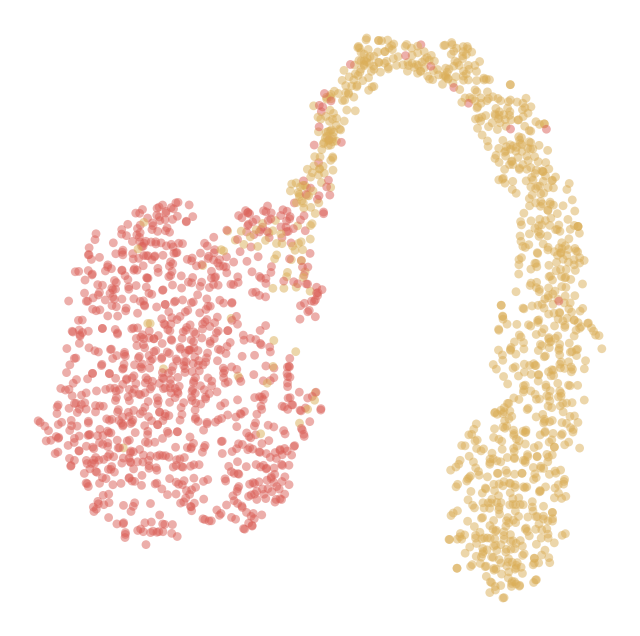

In [ ]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import matplotlib.patheffects as PathEffects
import pandas as pd


def scatter(x, labels, subtitle=None):
    # Create a scatter plot of the
    # the embeddings of the model.
    # We choose a color palette with seaborn.
    palette = np.array(sns.color_palette("hls", 10))
    # We create a scatter plot.
    f = plt.figure(figsize=(8, 8))
    ax = plt.subplot(aspect='equal')
    sc = ax.scatter(x[:,0], x[:,1], lw=0,alpha = 0.5, s=40,
                    c=palette[labels.astype(np.int)] )
    plt.xlim(-25, 25)
    plt.ylim(-25, 25)
    ax.axis('off')
    ax.axis('tight')



scatter(train_tsne_embeds, y_train[:sample_size])

In [ ]:
#base_model.save('embeddings_b1b2s_FINAL')

##Classifier

In [ ]:
# Create a Classifier that computes the class of a specific embedding.
#base_model = tfk.models.load_model('embeddings_large')
base_model.trainable = False

#Preprocessing layers
augmentation = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),
        tfkl.RandomContrast(0.1)
  ], name='augmentation')



Classifier_input = tfkl.Input(input_shape)
#x = augmentation(Classifier_input)
embeddings = base_model(Classifier_input)
x = tfkl.Dense(20, activation='relu')(embeddings)
x = tfkl.Dropout(0.2)(x)
x = tfkl.Dense(20, activation='relu')(x)
#x = tfkl.Dropout(0.4)(x)
#x = tfkl.Dense(20, activation='relu')(x)
#x = tfkl.Dropout(0.4)(x)
#x = tfkl.Dense(20, activation='relu')(x)
#x = tfkl.Dropout(0.4)(x)
#x = tfkl.Dense(20, activation='relu')(x)
Classifier_output = tfkl.Dense(2, activation='softmax')(x)
Classifier_model = tfk.Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
y_train_onehot = tfk.utils.to_categorical(y_train)
y_val_onehot = tfk.utils.to_categorical(y_val)
y_test_onehot = tfk.utils.to_categorical(y_test)

NameError: ignored

In [ ]:
Classifier_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 96, 96, 3)]       0         
                                                                 
 model (Functional)          (None, 20)                24148214  
                                                                 
 dense_3 (Dense)             (None, 20)                420       
                                                                 
 dropout_1 (Dropout)         (None, 20)                0         
                                                                 
 dense_4 (Dense)             (None, 20)                420       
                                                                 
 dense_5 (Dense)             (None, 2)                 42        
                                                                 
Total params: 24149096 (92.12 MB)
Trainable params: 882 (3.

In [ ]:
early_stopping2 = EarlyStopping(monitor='val_accuracy', mode='max', patience=3, start_from_epoch=0, restore_best_weights=True)

lr_patience = 2
lr_scheduler2 = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',# Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.5,            # Factor by which the learning rate will be reduced (0.9 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-6            # Minimum learning rate
)

In [ ]:
optimizer = tfk.optimizers.AdamW(1e-3)
optimizer = tfk.optimizers.Adam(1e-4)

In [ ]:
Classifier_model.compile(optimizer=optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
history = Classifier_model.fit(
              x = X_train,
              y = y_train_onehot,
              validation_data=(X_val,y_val_onehot),
              epochs=10,
              callbacks = [early_stopping2, lr_scheduler2]
          ).history

Epoch 1/10
124/124 [==============================] - 68s 331ms/step - loss: 0.6544 - accuracy: 0.6499 - val_loss: 0.6285 - val_accuracy: 0.9114 - lr: 1.0000e-04
Epoch 2/10
124/124 [==============================] - 30s 243ms/step - loss: 0.6022 - accuracy: 0.8879 - val_loss: 0.5743 - val_accuracy: 0.9122 - lr: 1.0000e-04
Epoch 3/10
124/124 [==============================] - 32s 262ms/step - loss: 0.5430 - accuracy: 0.9254 - val_loss: 0.5118 - val_accuracy: 0.9122 - lr: 1.0000e-04
Epoch 4/10
124/124 [==============================] - 33s 263ms/step - loss: 0.4715 - accuracy: 0.9360 - val_loss: 0.4425 - val_accuracy: 0.9122 - lr: 1.0000e-04
Epoch 5/10
124/124 [==============================] - 29s 237ms/step - loss: 0.4024 - accuracy: 0.9362 - val_loss: 0.3773 - val_accuracy: 0.9122 - lr: 1.0000e-04


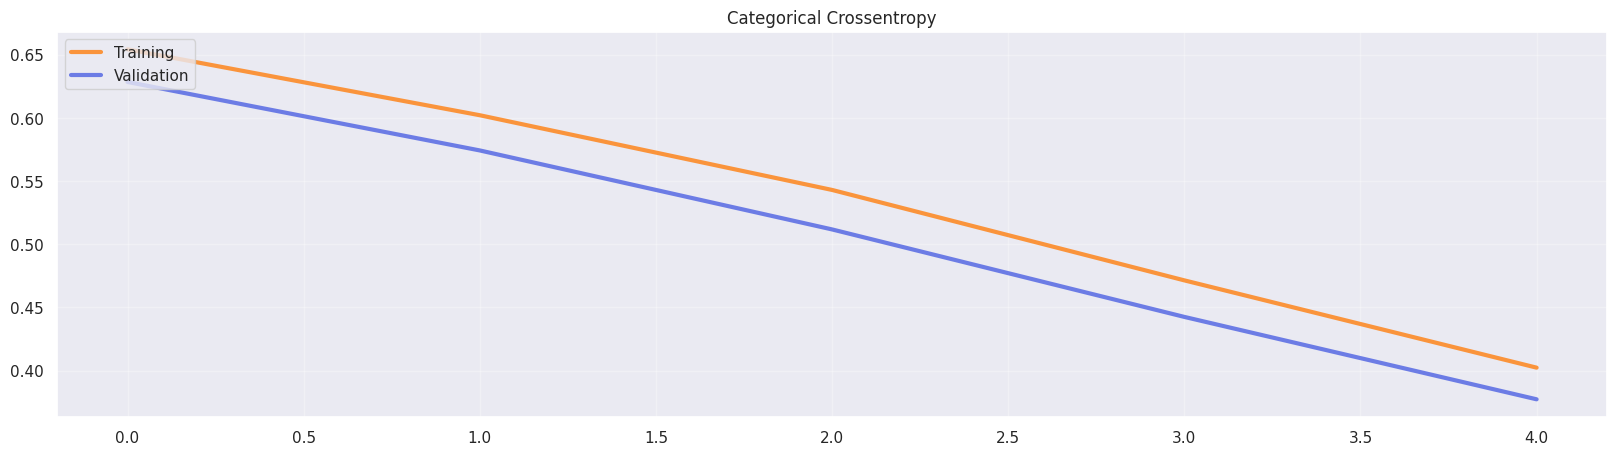

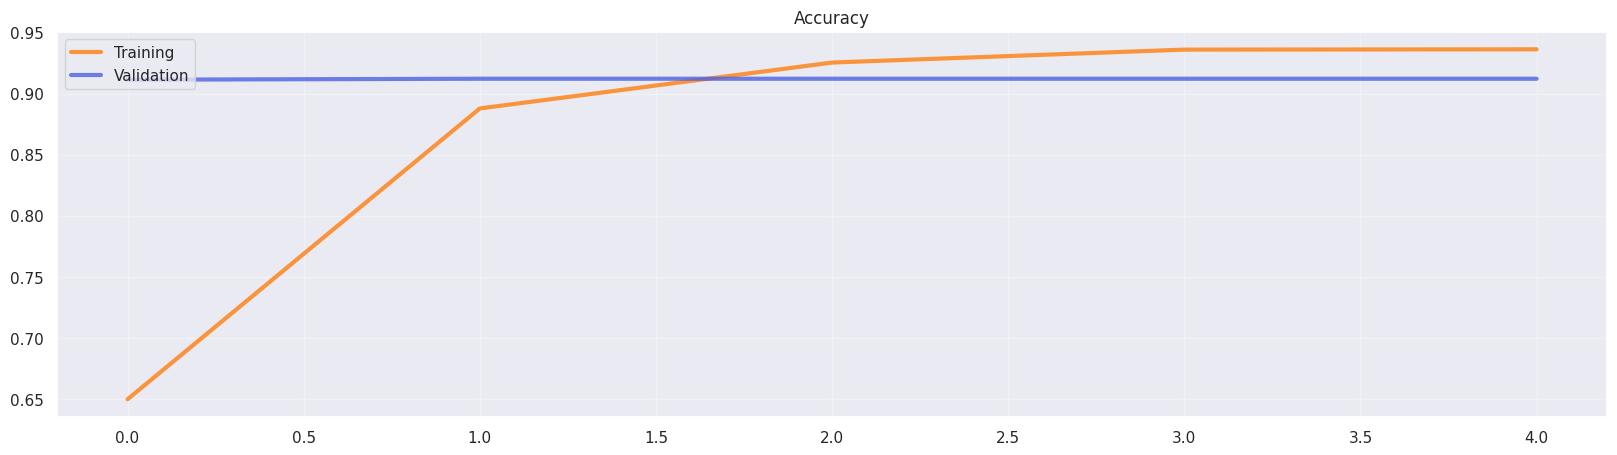

In [ ]:
# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
X_test.shape, y_test.shape, y_val.shape

((993, 96, 96, 3), (993,), (1241,))

In [ ]:
# Evaluate the model on the test set
test_accuracy = Classifier_model.evaluate(X_test,y_test_onehot,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.9063


In [ ]:
Classifier_model.save('siamese_triplet_model_large')

## Deep Classifier

In [ ]:
# Create a Classifier that computes the class of a specific embedding.
#base_model = tfk.models.load_model('embeddings_b0b3m_FINAL2')    # Using b0b3m didnt give amazing results
base_model.trainable = False

In [ ]:
#Preprocessing layers
augmentation = tf.keras.Sequential([
        tfkl.RandomBrightness(0.2),
        tfkl.RandomTranslation(0.2,0.2),
        tfkl.RandomFlip("horizontal_and_vertical"),
        tfkl.RandomRotation(0.2),
        tfkl.RandomZoom(0.2),
        tfkl.RandomContrast(0.1)
  ], name='augmentation')

num_layers = 12
num_hidden = 2

Classifier_input = tfkl.Input(input_shape)
#x = augmentation(Classifier_input)
embeddings = base_model(Classifier_input)
x = embeddings

# Initialize a list to store the skip connection outputs
skip_connections = []

# Build the specified number of hidden layers with skip connections
for i in range(num_layers):
    # Hidden layer
    hidden = tfkl.Dense(128, activation='relu',kernel_initializer=tfk.initializers.HeUniform(seed=seed), dtype='float32')(x)
    for j in range(num_hidden):
      hidden = tfkl.Dropout(0.2)(hidden)
      hidden = tfkl.Dense(128, activation='relu',kernel_initializer=tfk.initializers.HeUniform(seed=seed), dtype='float32')(hidden)

    # Dropout for regularization
    #dropout = tfkl.Dropout(0.2)(hidden)

    # Connect the current layer with all previous layers using skip connections
    for skip_layer in skip_connections:
        hidden = tfkl.Add()([hidden, skip_layer])

    # Update x for the next iteration
    x = tfkl.BatchNormalization()(hidden)

    # Store skip connection output
    skip_connections.append(x)

Classifier_output = tfkl.Dense(2, activation='softmax', kernel_initializer=tfk.initializers.GlorotUniform(seed=seed), dtype='float32')(x)
Classifier_model = tfk.Model(Classifier_input, Classifier_output)

# convert the target labels to onehot encoded vectors.
y_train_onehot = tfk.utils.to_categorical(y_train)
y_val_onehot = tfk.utils.to_categorical(y_val)
#y_test_onehot = tfk.utils.to_categorical(y_test)

In [ ]:
del y_train
del y_val
#del y_test

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 model (Functional)          (None, 20)                   7459426   ['input_1[0][0]']             
                                                          2                                       
                                                                                                  
 dense (Dense)               (None, 128)                  2688      ['model[0][0]']               
                                                                                                  
 dropout (Dropout)           (None, 128)                  0         ['dense[0][0]']           

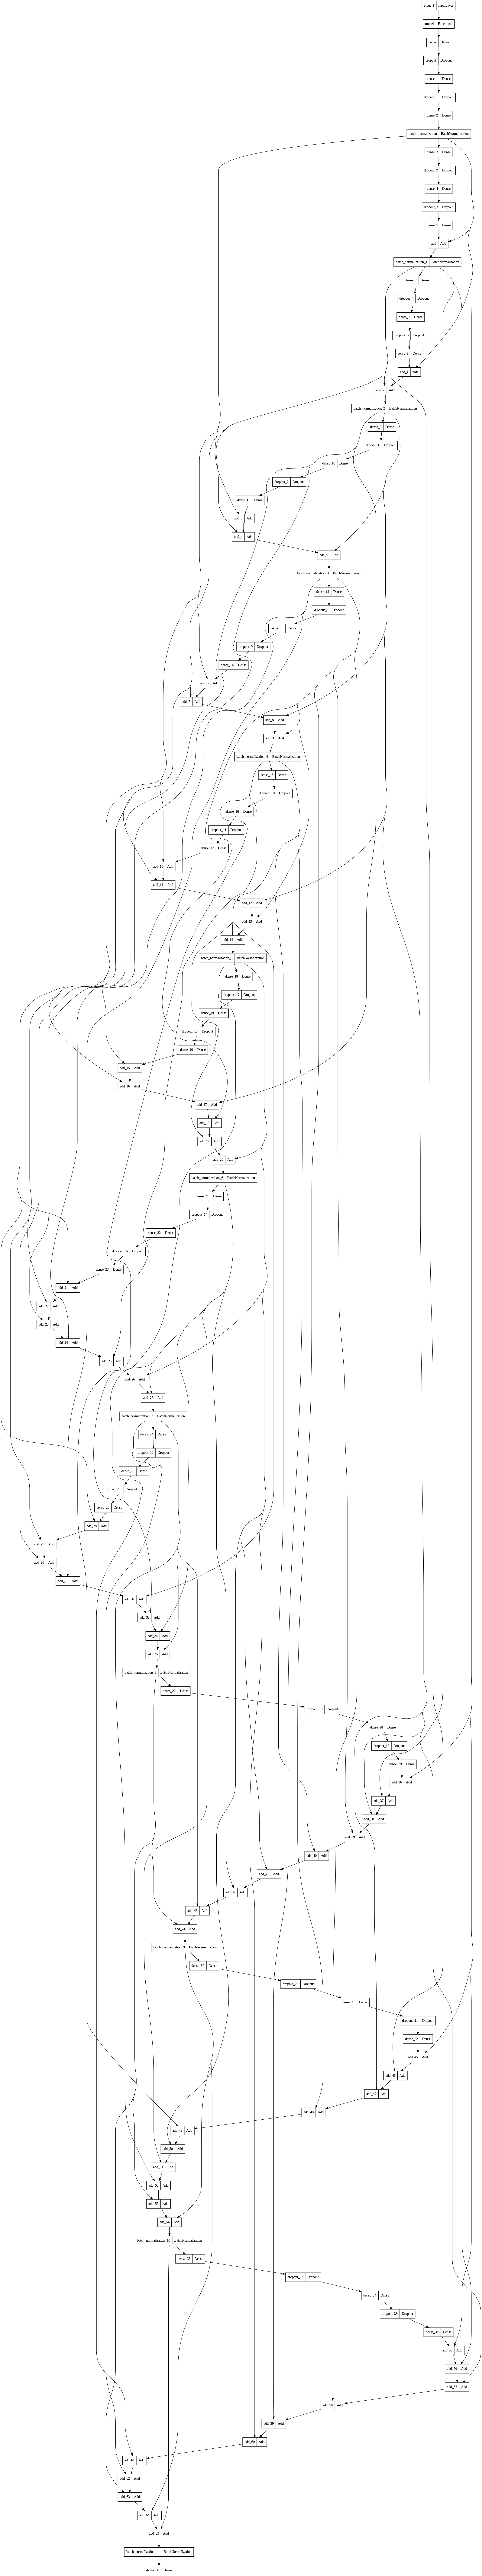

In [ ]:
Classifier_model.summary()
tfk.utils.plot_model(Classifier_model)

In [ ]:
early_stopping2 = EarlyStopping(monitor='val_accuracy', mode='max', patience=6, start_from_epoch=0, restore_best_weights=True)

lr_patience = 4
lr_scheduler2 = tfk.callbacks.ReduceLROnPlateau(
    monitor='val_loss',# Metric to monitor (validation mean squared error in this case)
    patience=lr_patience,  # Number of epochs with no improvement after which learning rate will be reduced
    factor=0.8,            # Factor by which the learning rate will be reduced (0.9 in this case)
    mode='min',            # Mode to decide when to reduce learning rate ('min' means reduce when metric stops decreasing)
    min_lr=1e-6            # Minimum learning rate
)

In [ ]:
optimizer = tfk.optimizers.Adam(1e-4)
mixed_precision_optimizer = tf.keras.mixed_precision.LossScaleOptimizer(optimizer)

In [ ]:
Classifier_model.compile(optimizer=mixed_precision_optimizer,loss='categorical_crossentropy',metrics=['accuracy'])
history = Classifier_model.fit(
              x = X_train,
              y = y_train_onehot,
              validation_data=(X_val,y_val_onehot),
              epochs=100,
              callbacks = [early_stopping2, lr_scheduler2]
          ).history

Epoch 1/100
175/175 [==============================] - 142s 464ms/step - loss: 0.5810 - accuracy: 0.7551 - val_loss: 0.4977 - val_accuracy: 0.7375 - lr: 1.0000e-04
Epoch 2/100
175/175 [==============================] - 68s 390ms/step - loss: 0.4034 - accuracy: 0.8450 - val_loss: 0.4140 - val_accuracy: 0.8325 - lr: 1.0000e-04
Epoch 3/100
175/175 [==============================] - 69s 393ms/step - loss: 0.3641 - accuracy: 0.8665 - val_loss: 0.3686 - val_accuracy: 0.8438 - lr: 1.0000e-04
Epoch 4/100
175/175 [==============================] - 69s 392ms/step - loss: 0.3426 - accuracy: 0.8697 - val_loss: 0.3684 - val_accuracy: 0.8390 - lr: 1.0000e-04
Epoch 5/100
175/175 [==============================] - 69s 397ms/step - loss: 0.3340 - accuracy: 0.8740 - val_loss: 0.3410 - val_accuracy: 0.8535 - lr: 1.0000e-04
Epoch 6/100
175/175 [==============================] - 70s 399ms/step - loss: 0.3213 - accuracy: 0.8791 - val_loss: 0.3263 - val_accuracy: 0.8647 - lr: 1.0000e-04
Epoch 7/100
175/175 [

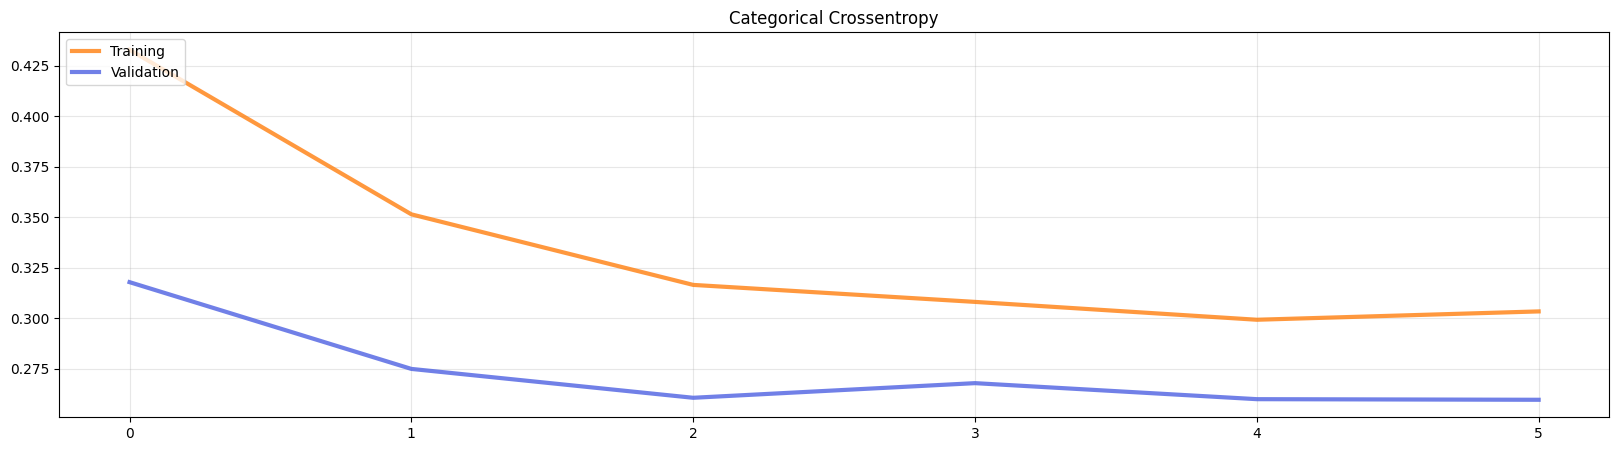

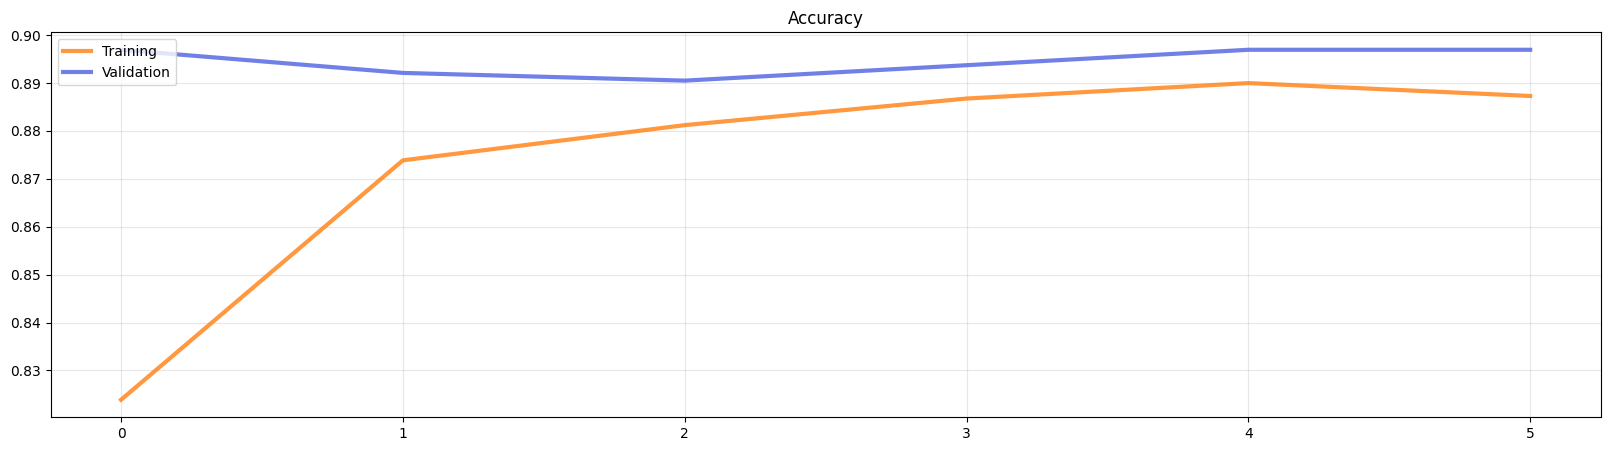

In [ ]:
# Plot training and validation performance metrics
plt.figure(figsize=(20, 5))

# Plot training and validation loss
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_loss'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=0.3)

plt.figure(figsize=(20, 5))

# Plot training and validation accuracy, highlighting the best epoch
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=3)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.8, color='#4D61E2', linewidth=3)
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=0.3)

plt.show()

In [ ]:
X_test.shape, y_test.shape, y_val.shape

((993, 96, 96, 3), (993,), (1241,))

In [ ]:
# Evaluate the model on the test set
test_accuracy = Classifier_model.evaluate(X_test,y_test_onehot,verbose=0)[-1]
print('Test set accuracy %.4f' % test_accuracy)

Test set accuracy 0.8550


In [ ]:
#Classifier_model.save('b0b3m_FINAL')